In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd

from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

import lm_eval
from lm_eval.models.huggingface import HFLM

In [2]:
device = torch.device('cuda:3')
torch.set_default_device(device)

In [3]:
model_name = 'microsoft/phi-2' 

tokenizer = AutoTokenizer.from_pretrained(model_name, output_hidden_states=True)
model = AutoModelForCausalLM.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Divergence Plots

In [4]:
def sm_wassertain(logits1, logits2):
    prob1 = F.softmax(logits1, dim=-1)
    prob2 = F.softmax(logits2, dim=-1)
    
    cdf1 = torch.cumsum(prob1, dim=-1)
    cdf2 = torch.cumsum(prob2, dim=-1)
    
    wasserstein_dist = torch.sum(torch.abs(cdf1 - cdf2), dim=-1)
    
    return wasserstein_dist.mean()

In [5]:
def kl_div(p, q, epsilon=1e-10):
    p = p + epsilon
    q = q + epsilon
    return (p * (torch.log2(p) - torch.log2(q))).sum()

def sm_jsd(p, q):
    """Returns the Jensen-Shannon Divergence of softmax-ed logits"""
    p = F.softmax(p, dim=-1)
    q = F.softmax(q, dim=-1)
    m = 0.5 * (p + q)
    return 0.5 * kl_div(p, m) + 0.5 * kl_div(q, m)

In [6]:
def plot_divs(prompt, model=model,tokenizer=tokenizer, div_func = sm_jsd, instruct=True):
    prompt = f"Instruct: {prompt}\nOutput:" if instruct else prompt
    input_ids = tokenizer( prompt, return_tensors='pt')
    prompt_len = input_ids.input_ids.shape[-1]

    output = model.generate(**input_ids, max_length=500, return_dict_in_generate=True, output_hidden_states=True, use_cache=True)
    total_len = output.sequences[0].shape[-1]
    gen_len = total_len - prompt_len
    gen_text = tokenizer.decode(output.sequences[0])
    print(gen_text)
    data = np.ndarray((gen_len, 32))
    column_labels = []

    for i, hs_per_tok in enumerate(output.hidden_states):
        tok = tokenizer.decode(output.sequences[0][prompt_len + i])
        column_labels.append(tok)
        final_logits = model.lm_head(hs_per_tok[-1])[:, -1, :].unsqueeze(0)
        for j, hs_per_tok_layer in enumerate(hs_per_tok[:-1]):
            last_hs = hs_per_tok_layer[:, -1, :].unsqueeze(0)
            logits = model.lm_head(model.model.final_layernorm(last_hs))
            data[i][j] = div_func(logits, final_logits).item()
    
    row_labels = [f'Dec {i}' for i in range(32, 0, -1)]  

    data_tposed = data.T[::-1]

    plt.figure(figsize=(24, 12))
    sns.heatmap(data_tposed, annot=True, cmap='coolwarm', cbar=True, xticklabels=column_labels, yticklabels=row_labels)

    plt.gca().xaxis.set_ticks_position('top')
    plt.xticks(rotation=0)

    plt.show()


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Instruct: What is the value of speed of light?
Output: The value of speed of light is approximately 299,792,458 meters per second.
<|endoftext|>


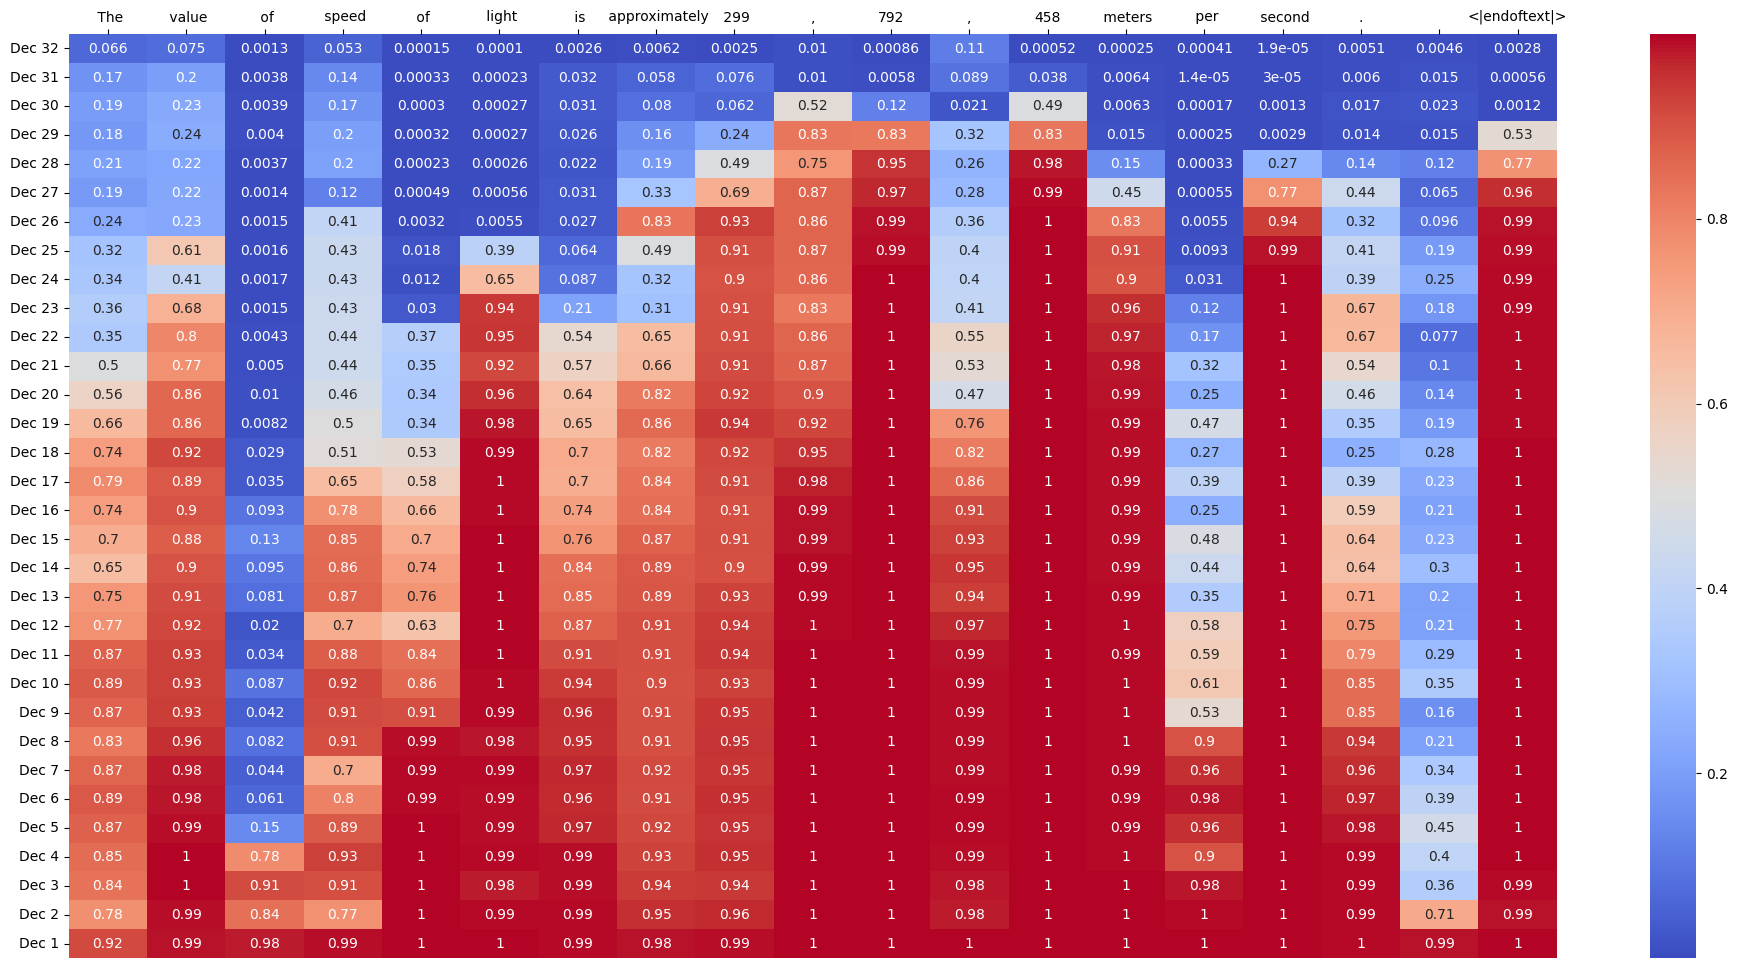

In [7]:
plot_divs("What is the value of speed of light?")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Instruct: What happens when you eat watermelon seeds?
Output: When you eat watermelon seeds, they pass through your digestive system without causing any harm. They are not toxic or harmful to your health.
<|endoftext|>


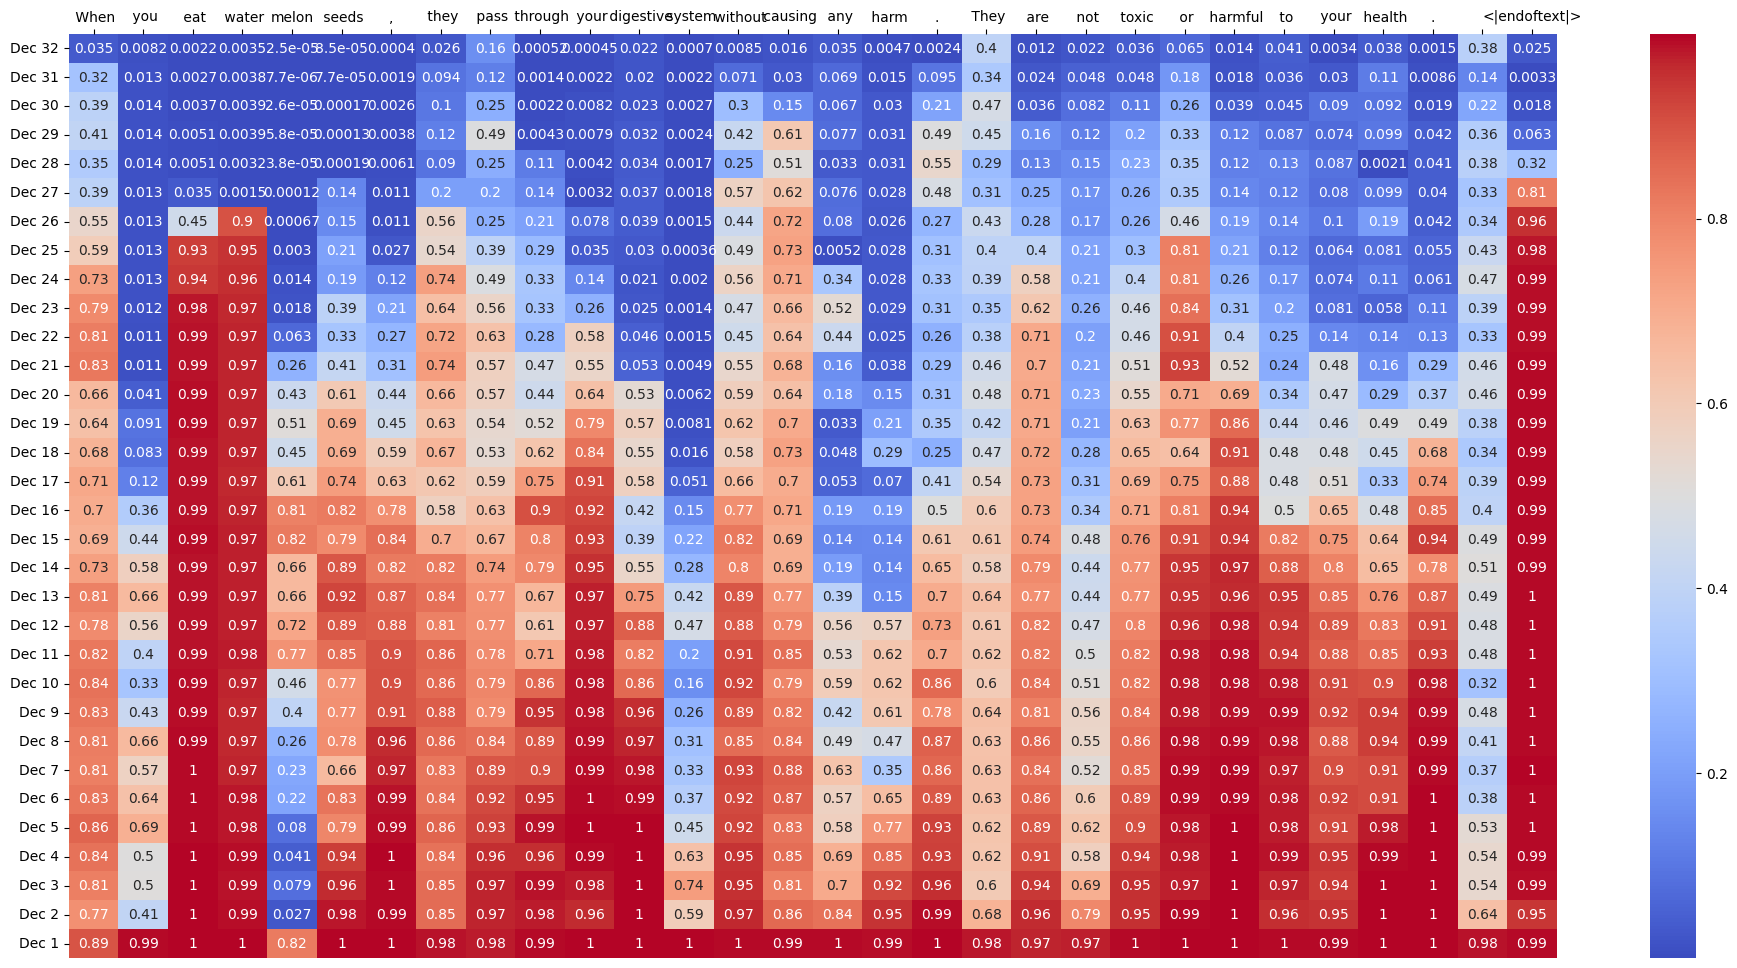

In [8]:
plot_divs("What happens when you eat watermelon seeds?")

In [15]:
lm_obj = HFLM(pretrained=model, tokenizer=tokenizer)
results = lm_eval.simple_evaluate(
    model=lm_obj,
    tasks=["truthfulqa"],
    num_fewshot=0,
    limit=10,
    log_samples=False)

2024-05-29:05:45:07,580 WARNING  [huggingface.py:118] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-05-29:05:45:07,591 WARNING  [huggingface.py:337] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
2024-05-29:05:45:07,593 INFO     [evaluator.py:131] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234
2024-05-29:05:45:17,460 INFO     [evaluator.py:218] num_fewshot has been set to 0 for truthfulqa_mc1 in its config. Manual configuration will be ignored.
2024-05-29:05:45:17,461 INFO     [evaluator.py:218] num_fewshot has been set to 0 for truthfulqa_mc2 in its config. Manual configuration will be ignored.
2024-05-29:05:45:17,462 INFO     [evaluator.py:218] num_fewshot has been set to 0 for truthfulqa_gen in its config. 

In [16]:
df = pd.DataFrame(results['results']).transpose()
df['Baseline Accuracy'] = df[['acc,none','acc_stderr,none']].apply(lambda x : '{} ± {}'.format(round(x[0],2), round(x[1], 4)), axis=1)
df[['Baseline Accuracy']]

/tmp/ipykernel_1017971/3071663309.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['Baseline Accuracy'] = df[['acc,none','acc_stderr,none']].apply(lambda x : '{} ± {}'.format(round(x[0],2), round(x[1], 4)), axis=1)


,Baseline Accuracy
truthfulqa,0.51 ± 0.1097
truthfulqa_gen,nan ± nan
truthfulqa_mc1,0.4 ± 0.1633
truthfulqa_mc2,0.61 ± 0.1465


In [17]:
prompt = f"Instruct: What happens when you eat watermelon seeds?\nOutput:"
input_ids = tokenizer( prompt, return_tensors='pt')
prompt_len = input_ids.input_ids.shape[-1]

output = model(**input_ids, output_hidden_states=True, use_cache=True)


In [18]:
from typing import Optional, Union, Tuple, List

from torch.nn import CrossEntropyLoss

from transformers.models.phi.modeling_phi import PhiForCausalLM
from transformers.modeling_outputs import CausalLMOutputWithPast


# Some code snippets were copied from transformers.models.phi.modeling_phi.PhiForCausalLM.forward()
class PhiDOLa(PhiForCausalLM):
    def __init__(self, config):
        super().__init__(config)
        self.final_layernorm = torch.nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(
            self,
            input_ids: torch.LongTensor = None,
            attention_mask: Optional[torch.Tensor] = None,
            position_ids: Optional[torch.LongTensor] = None,
            past_key_values: Optional[List[torch.FloatTensor]] = None,
            inputs_embeds: Optional[torch.FloatTensor] = None,
            labels: Optional[torch.LongTensor] = None,
            use_cache: Optional[bool] = None,
            output_attentions: Optional[bool] = None,
            output_hidden_states: Optional[bool] = None,
            return_dict: Optional[bool] = None,
        ) -> Union[Tuple, CausalLMOutputWithPast]:

            output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
            output_hidden_states = True
            return_dict = return_dict if return_dict is not None else self.config.use_return_dict

            # decoder outputs consists of (dec_features, layer_state, dec_hidden, dec_attn)
            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                position_ids=position_ids,
                past_key_values=past_key_values,
                inputs_embeds=inputs_embeds,
                use_cache=use_cache,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )

            hidden_states = outputs[0]
            logits = hidden_states 
            logits = self.lm_head(hidden_states)
            logits = logits.float()


            # max_jsd = float('-inf')
            # max_logits = None
            jsd_list = []
            logits_list = []
            eps = 1e-8

            for mul, hidden_state in enumerate(outputs.hidden_states[:-1]):
                int_logits = self.lm_head(self.final_layernorm(hidden_state)).float()
                logits_list.append(int_logits)
                int_jsd =  sm_jsd(logits[-1], int_logits[-1])
                jsd_list.append(int_jsd.item()/(mul + eps))  
            jsd_tensor = torch.tensor(jsd_list)
            inverse_jsd_tensor = -jsd_tensor 
            weights = F.softmax(inverse_jsd_tensor, dim=-1)

            weighted_logits = torch.zeros_like(logits_list[0])
            for i, logits_ in enumerate(logits_list):
                weighted_logits += weights[i] * logits_

            logits = weighted_logits
            # if curr_jsd > max_jsd:
            #     max_jsd = curr_jsd
            #     max_logits = temp

            # logits[-1] -= max_logits[-1]

            loss = None
            if labels is not None:
                # Shift so that tokens < n predict n
                shift_logits = logits[..., :-1, :].contiguous()
                shift_labels = labels[..., 1:].contiguous()
                # Flatten the tokens
                loss_fct = CrossEntropyLoss()
                shift_logits = shift_logits.view(-1, self.config.vocab_size)
                shift_labels = shift_labels.view(-1)
                # Enable model parallelism
                shift_labels = shift_labels.to(shift_logits.device)
                loss = loss_fct(shift_logits, shift_labels)

            if not return_dict:
                output = (logits,) + outputs[1:]
                return (loss,) + output if loss is not None else output

            return CausalLMOutputWithPast(
                loss=loss,
                logits=logits,
                past_key_values=outputs.past_key_values,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions,
            )

In [19]:
# del dola_model
dola_model = PhiDOLa.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of PhiDOLa were not initialized from the model checkpoint at microsoft/phi-2 and are newly initialized: ['final_layernorm.bias', 'final_layernorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
lm_obj = HFLM(pretrained=dola_model, tokenizer=tokenizer)
results = lm_eval.simple_evaluate(
    model=lm_obj,
    tasks=["truthfulqa"],
    num_fewshot=0,
    limit=10)

2024-05-29:05:45:36,827 WARNING  [huggingface.py:118] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-05-29:05:45:36,852 WARNING  [huggingface.py:337] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
2024-05-29:05:45:36,853 INFO     [evaluator.py:131] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234


2024-05-29:05:45:47,494 INFO     [evaluator.py:218] num_fewshot has been set to 0 for truthfulqa_mc1 in its config. Manual configuration will be ignored.
2024-05-29:05:45:47,495 INFO     [evaluator.py:218] num_fewshot has been set to 0 for truthfulqa_mc2 in its config. Manual configuration will be ignored.
2024-05-29:05:45:47,496 INFO     [evaluator.py:218] num_fewshot has been set to 0 for truthfulqa_gen in its config. Manual configuration will be ignored.
2024-05-29:05:45:47,498 INFO     [task.py:395] Building contexts for truthfulqa_mc1 on rank 0...
100%|██████████| 10/10 [00:00<00:00, 1088.47it/s]
2024-05-29:05:45:47,511 INFO     [task.py:395] Building contexts for truthfulqa_mc2 on rank 0...
100%|██████████| 10/10 [00:00<00:00, 1070.44it/s]
2024-05-29:05:45:47,524 INFO     [task.py:395] Building contexts for truthfulqa_gen on rank 0...
100%|██████████| 10/10 [00:00<00:00, 1856.22it/s]
2024-05-29:05:45:47,535 INFO     [evaluator.py:362] Running loglikelihood requests
Running loglik

In [21]:
df_dola = pd.DataFrame(results['results']).transpose()
df['DOLa Accuracy'] = df_dola[['acc,none','acc_stderr,none']].apply(lambda x : '{} ± {}'.format(round(x[0],2), round(x[1], 4)), axis=1)
df[['Baseline Accuracy','DOLa Accuracy' ]]

/tmp/ipykernel_1017971/1554511284.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['DOLa Accuracy'] = df_dola[['acc,none','acc_stderr,none']].apply(lambda x : '{} ± {}'.format(round(x[0],2), round(x[1], 4)), axis=1)


,Baseline Accuracy,DOLa Accuracy
truthfulqa,0.51 ± 0.1097,0.56 ± 0.1097
truthfulqa_gen,nan ± nan,nan ± nan
truthfulqa_mc1,0.4 ± 0.1633,0.5 ± 0.1667
truthfulqa_mc2,0.61 ± 0.1465,0.63 ± 0.1427


In [12]:
df

NameError: name 'df' is not defined

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Instruct: What is the value of speed of light?
Output: The value of the "s" in the "s-1" is not a "s-1" "s-1" "s-1" "s-1" "s-1" "s-1" "s-1" "s-1" "s-1" "s-1" "s-1" "s-1" "s-1" "s-1" "s-1" "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s-1 "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s- "s


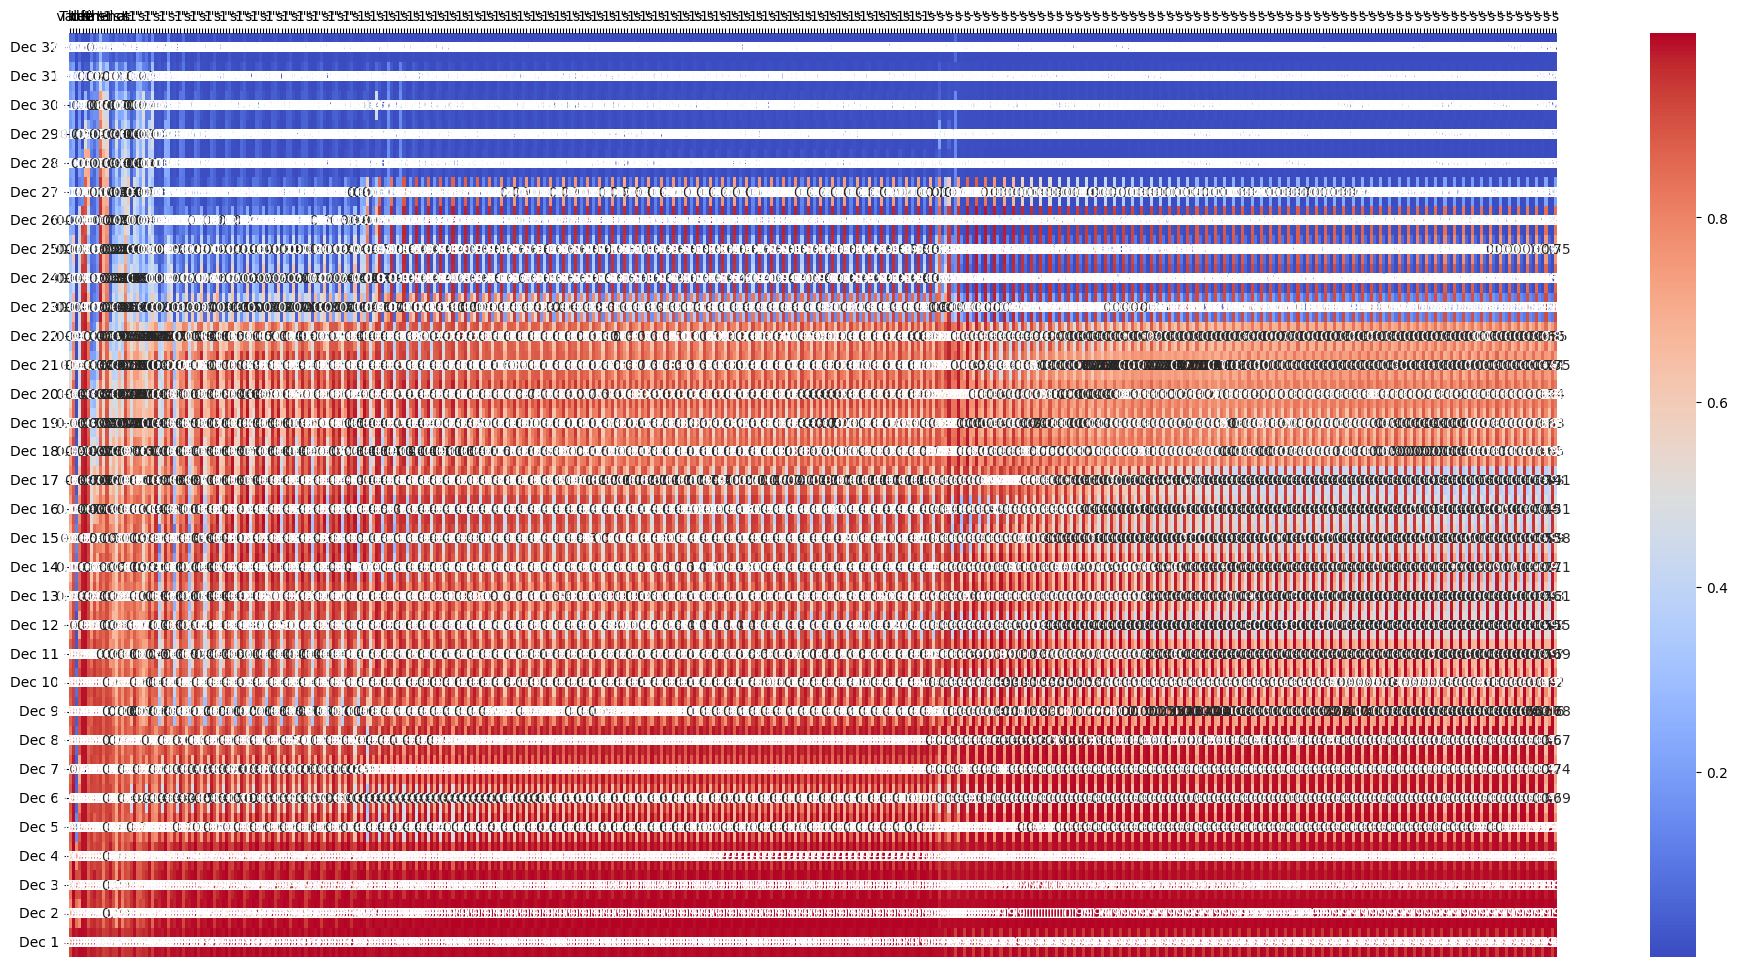

In [21]:
plot_divs("What is the value of speed of light?", model=dola_model)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Instruct: What is the value of speed of light?
Output: ValueError: Speed of light must not be NaN or infinity.
<|endoftext|>


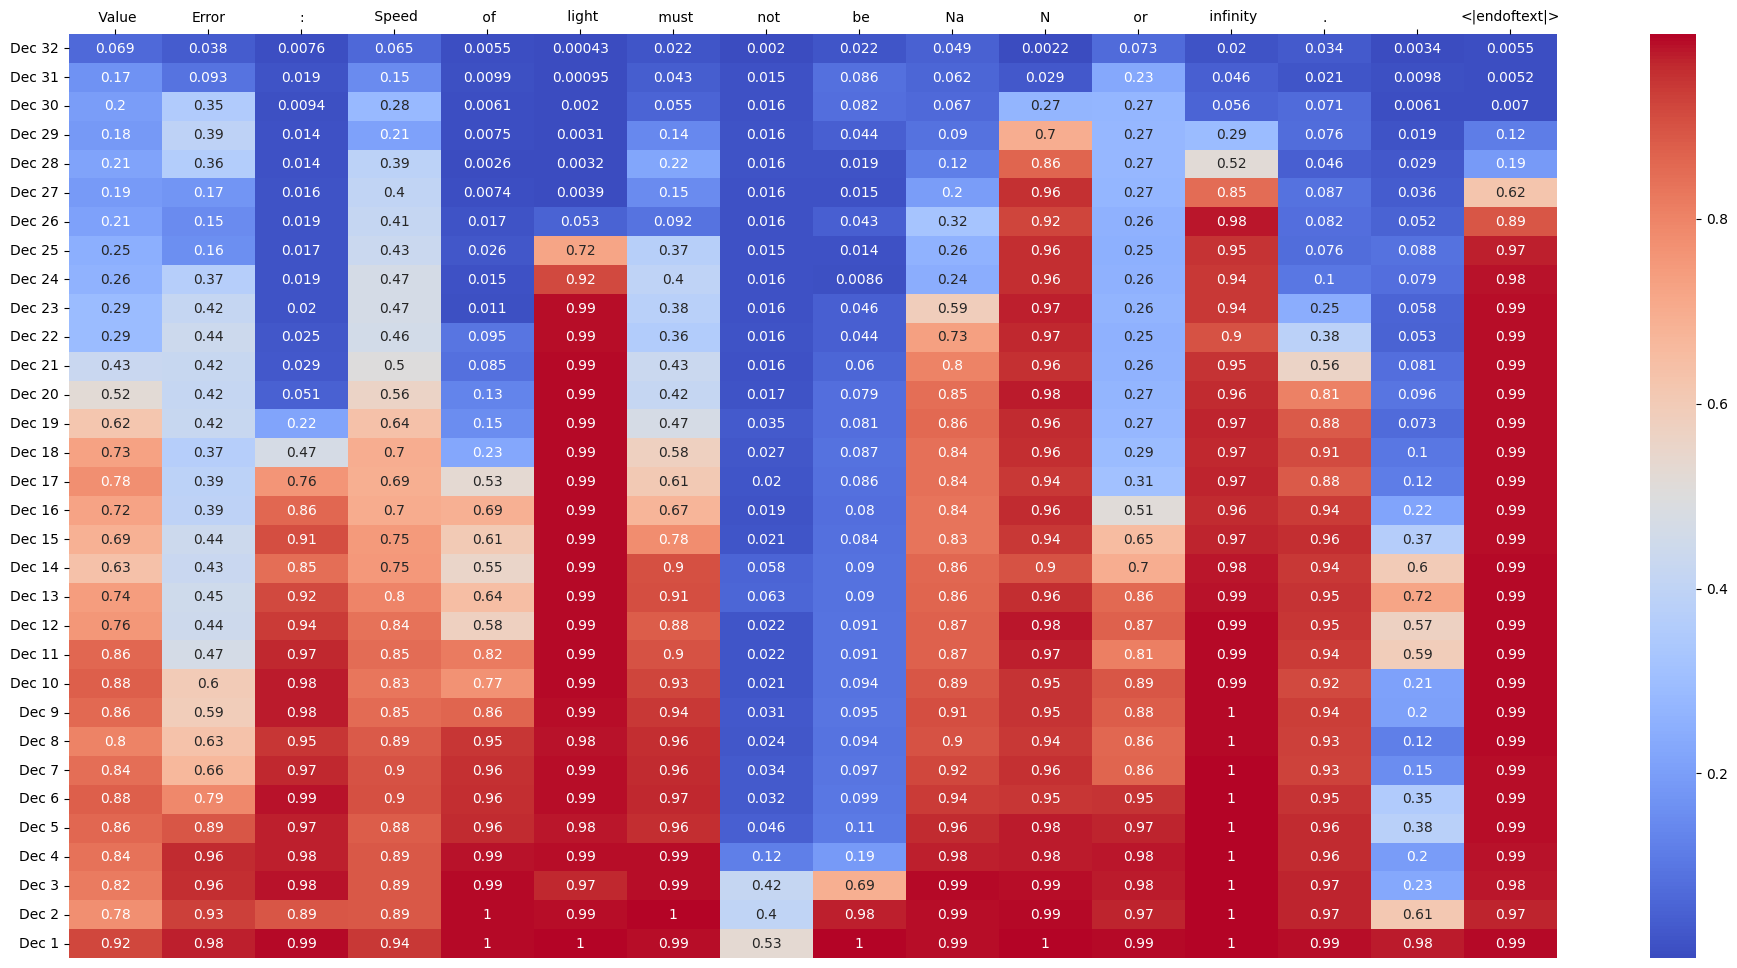

In [38]:
plot_jsd("What is the value of speed of light?", model=dolare_model)

In [8]:
from typing import Optional, Union, Tuple, List

from torch.nn import CrossEntropyLoss

from transformers.models.phi.modeling_phi import PhiForCausalLM, PhiModel, PhiConfig
from transformers.modeling_outputs import CausalLMOutputWithPast, BaseModelOutputWithPast
from transformers.modeling_attn_mask_utils import (
    _prepare_4d_causal_attention_mask,
    _prepare_4d_causal_attention_mask_for_sdpa,
)
from transformers.cache_utils import Cache, DynamicCache


class PhiModelDOLaRE(PhiModel):
    def __init__(self, config: PhiConfig):
        super().__init__(config)
        self.alpha = [0.0 for _ in range(config.num_hidden_layers)]


    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPast]:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # retrieve input_ids and inputs_embeds
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            batch_size, seq_length = input_ids.shape[:2]
        elif inputs_embeds is not None:
            batch_size, seq_length = inputs_embeds.shape[:2]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        past_key_values_length = 0

        if self.gradient_checkpointing and self.training:
            if use_cache:
                logger.warning_once(
                    "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                )
                use_cache = False

        if use_cache:
            use_legacy_cache = not isinstance(past_key_values, Cache)
            if use_legacy_cache:
                past_key_values = DynamicCache.from_legacy_cache(past_key_values)
            past_key_values_length = past_key_values.get_usable_length(seq_length)

        if position_ids is None:
            device = input_ids.device if input_ids is not None else inputs_embeds.device
            position_ids = torch.arange(
                past_key_values_length, seq_length + past_key_values_length, dtype=torch.long, device=device
            )
            position_ids = position_ids.unsqueeze(0)

        if inputs_embeds is None:
            inputs_embeds = self.embed_tokens(input_ids)

        inputs_embeds = self.embed_dropout(inputs_embeds)

        # Attention mask.
        if self._use_flash_attention_2:
            # 2d mask is passed through the layers
            attention_mask = attention_mask if (attention_mask is not None and 0 in attention_mask) else None
        elif self._use_sdpa and not output_attentions:
            attention_mask = _prepare_4d_causal_attention_mask_for_sdpa(
                attention_mask,
                (batch_size, seq_length),
                inputs_embeds,
                past_key_values_length,
            )
        else:
            # 4d mask is passed through the layers
            attention_mask = _prepare_4d_causal_attention_mask(
                attention_mask, (batch_size, seq_length), inputs_embeds, past_key_values_length
            )

        hidden_states = inputs_embeds

        # decoder layers
        all_hidden_states = () if output_hidden_states else None
        all_self_attns = () if output_attentions else None
        next_decoder_cache = None

        for id, decoder_layer in enumerate(self.layers):
            if output_hidden_states:
                all_hidden_states += (hidden_states,)

            if self.gradient_checkpointing and self.training:
                layer_outputs = self._gradient_checkpointing_func(
                    decoder_layer.__call__,
                    hidden_states,
                    attention_mask,
                    position_ids,
                    past_key_values,
                    output_attentions,
                )
            else:
                layer_outputs = decoder_layer(
                    hidden_states,
                    attention_mask=attention_mask,
                    position_ids=position_ids,
                    past_key_value=past_key_values,
                    output_attentions=output_attentions,
                    use_cache=use_cache,
                )

            hidden_states = self.alpha[id] * layer_outputs[0] + (1 - self.alpha[id]) * hidden_states

            if use_cache:
                next_decoder_cache = layer_outputs[2 if output_attentions else 1]

            if output_attentions:
                all_self_attns += (layer_outputs[1],)

        hidden_states = self.final_layernorm(hidden_states)

        # add hidden states from the last decoder layer
        if output_hidden_states:
            all_hidden_states += (hidden_states,)

        next_cache = None
        if use_cache:
            next_cache = next_decoder_cache.to_legacy_cache() if use_legacy_cache else next_decoder_cache
        if not return_dict:
            return tuple(v for v in [hidden_states, next_cache, all_hidden_states, all_self_attns] if v is not None)
        return BaseModelOutputWithPast(
            last_hidden_state=hidden_states,
            past_key_values=next_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attns,
        )

# Some code snippets were copied from transformers.models.phi.modeling_phi.PhiForCausalLM.forward()
class PhiDOLaRE(PhiForCausalLM):
    def __init__(self, config):
        super().__init__(config)
        self.final_layernorm = torch.nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.model = PhiModelDOLaRE(config)

    def forward(
            self,
            input_ids: torch.LongTensor = None,
            attention_mask: Optional[torch.Tensor] = None,
            position_ids: Optional[torch.LongTensor] = None,
            past_key_values: Optional[List[torch.FloatTensor]] = None,
            inputs_embeds: Optional[torch.FloatTensor] = None,
            labels: Optional[torch.LongTensor] = None,
            use_cache: Optional[bool] = None,
            output_attentions: Optional[bool] = None,
            output_hidden_states: Optional[bool] = None,
            return_dict: Optional[bool] = None,
        ) -> Union[Tuple, CausalLMOutputWithPast]:

            output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
            output_hidden_states = True
            return_dict = return_dict if return_dict is not None else self.config.use_return_dict

            # decoder outputs consists of (dec_features, layer_state, dec_hidden, dec_attn)
            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                position_ids=position_ids,
                past_key_values=past_key_values,
                inputs_embeds=inputs_embeds,
                use_cache=use_cache,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )
            # outputs = self.model(
            #     input_ids=input_ids,
            #     attention_mask=attention_mask,
            #     position_ids=position_ids,
            #     past_key_values=past_key_values,
            #     inputs_embeds=inputs_embeds,
            #     use_cache=use_cache,
            #     output_attentions=output_attentions,
            #     output_hidden_states=output_hidden_states,
            #     return_dict=return_dict,
            # )


            hidden_states = outputs[0]
            logits = hidden_states 
            logits = self.lm_head(hidden_states)
            logits = logits.float()

            intermediate_outputs = ()

            max_jsd = float('-inf')
            max_logits = None

            logit_list = []

            for id, hidden_state in enumerate(outputs.hidden_states[:-1]):
                temp = self.lm_head(self.final_layernorm(hidden_state)).float()
                curr_jsd = sm_jsd(logits[-1], temp[-1])

                # logit_list.append((curr_jsd, temp))

                if curr_jsd >= max_jsd:
                    max_jsd = curr_jsd
                    max_logits = temp


            logits[-1] -= max_logits[-1]

            loss = None
            if labels is not None:
                # Shift so that tokens < n predict n
                shift_logits = logits[..., :-1, :].contiguous()
                shift_labels = labels[..., 1:].contiguous()
                # Flatten the tokens
                loss_fct = CrossEntropyLoss()
                shift_logits = shift_logits.view(-1, self.config.vocab_size)
                shift_labels = shift_labels.view(-1)
                # Enable model parallelism
                shift_labels = shift_labels.to(shift_logits.device)
                loss = loss_fct(shift_logits, shift_labels)

            if not return_dict:
                output = (logits,) + outputs[1:]
                return (loss,) + output if loss is not None else output

            return CausalLMOutputWithPast(
                loss=loss,
                logits=logits,
                past_key_values=outputs.past_key_values,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions,
            )

In [9]:
torch.set_default_device('cuda:2')
dolare_model = PhiDOLaRE.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of PhiDOLaRE were not initialized from the model checkpoint at microsoft/phi-2 and are newly initialized: ['final_layernorm.bias', 'final_layernorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
lm_obj = HFLM(pretrained=dolare_model, tokenizer=tokenizer)
results = lm_eval.simple_evaluate(
    model=lm_obj,
    tasks=["truthfulqa"],
    num_fewshot=0,
    limit=100)

2024-05-29:03:50:35,620 WARNING  [huggingface.py:118] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-05-29:03:50:35,640 WARNING  [huggingface.py:337] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
2024-05-29:03:50:35,642 INFO     [evaluator.py:131] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234
2024-05-29:03:50:47,959 INFO     [evaluator.py:218] num_fewshot has been set to 0 for truthfulqa_mc1 in its config. Manual configuration will be ignored.
2024-05-29:03:50:47,960 INFO     [evaluator.py:218] num_fewshot has been set to 0 for truthfulqa_mc2 in its config. Manual configuration will be ignored.
2024-05-29:03:50:47,960 INFO     [evaluator.py:218] num_fewshot has been set to 0 for truthfulqa_gen in its config. 

In [11]:
df_dolare = pd.DataFrame(results['results']).transpose()
df['DOLaRE Accuracy'] = df_dolare[['acc,none','acc_stderr,none']].apply(lambda x : '{} ± {}'.format(round(x[0],2), round(x[1], 4)), axis=1)
df[['Baseline Accuracy','DOLaRE Accuracy']]

/tmp/ipykernel_795346/332395543.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['DOLaRE Accuracy'] = df_dolare[['acc,none','acc_stderr,none']].apply(lambda x : '{} ± {}'.format(round(x[0],2), round(x[1], 4)), axis=1)


NameError: name 'df' is not defined

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Instruct: What is the value of speed of light?
Output:








































































































































































































































































































































































































































































































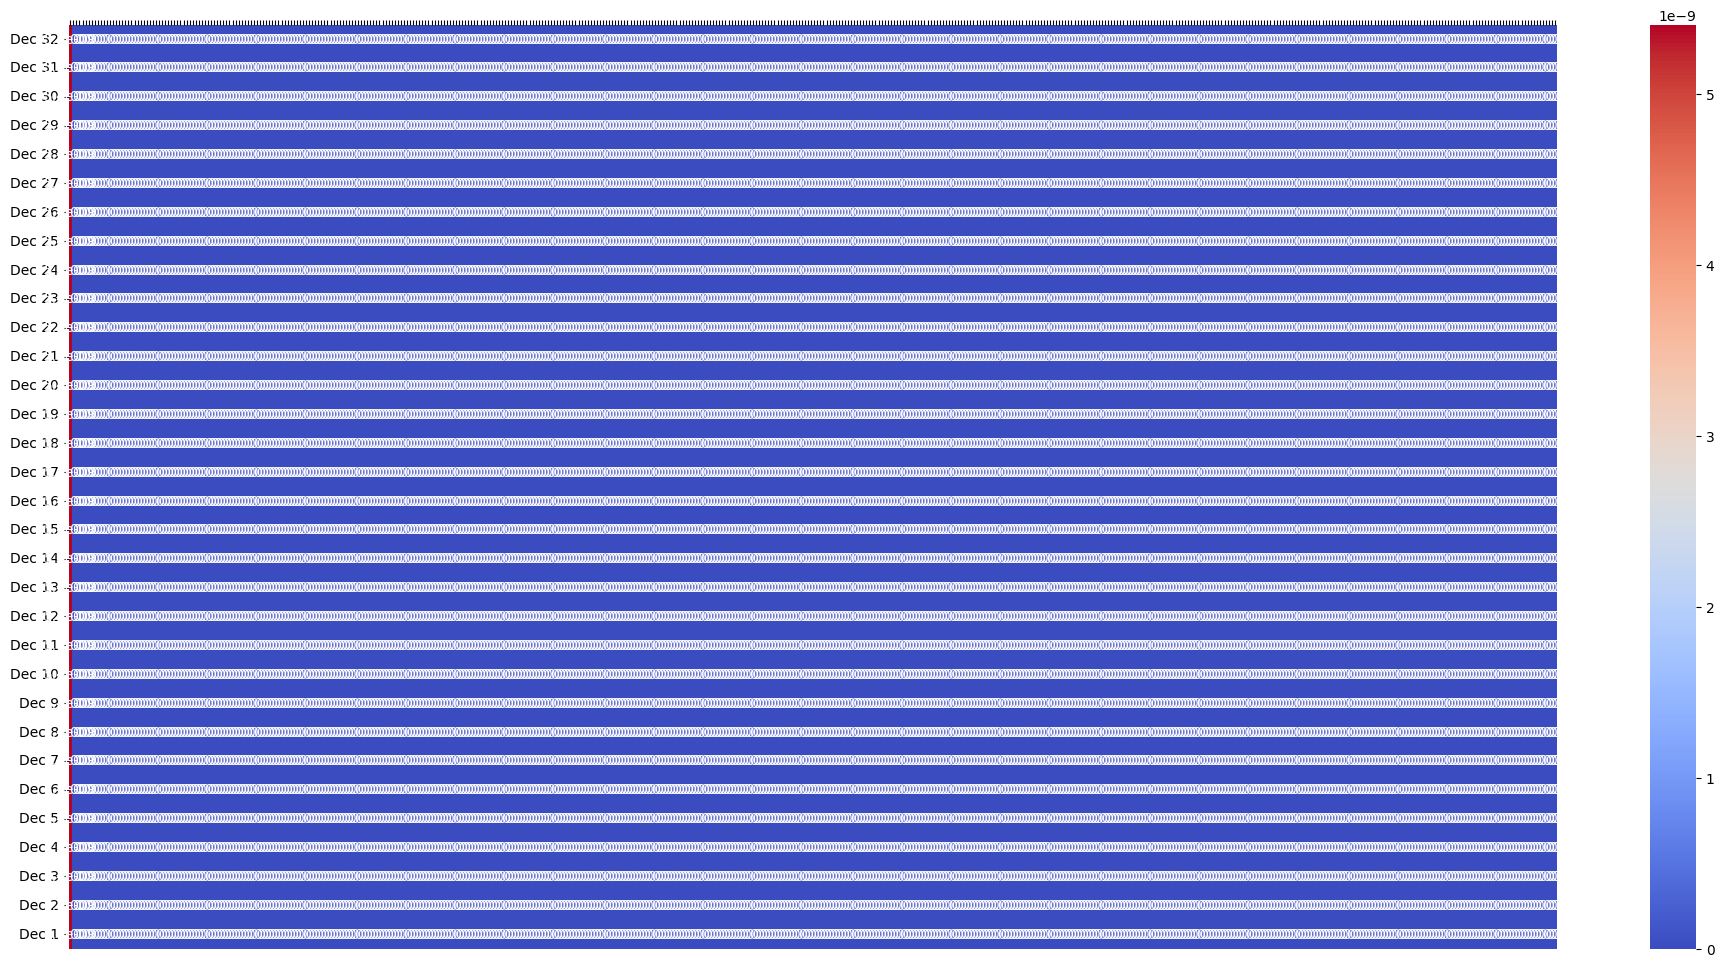

In [48]:
plot_jsd("What is the value of speed of light?", model=dolare_model)